In [1]:
import pandas as pd
import seaborn as sns
import pandas_gbq
import tqdm
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file(
    'trumid-case-8a70bafcd63d.json',
)
pandas_gbq.context.credentials = credentials

In [2]:
# Update the in-memory credentials cache (added in pandas-gbq 0.7.0).
pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = "trumid-case"

# Question 1: 

Assess the profitability of each product category. Are there significant differences between
them? If so, what might TheLook consider changing about its product mix to increase margins
overall?

## Data Exploration

 *  In `products`, are both `ID` and `sku` unique? **Yes**
 *  Does every item in `inventory_items` have a corresponding record in `products`? **Yes**
 *  Does the `cost` in `products` always match the cost in `inventory items`? **Yes**
 *  Does the `sale price` in `products` always match the `retail price` in `order items`? **Yes** <- So no sales?
 *  How often are items sold at below list price? (i.e. at a discount?) <- **Never! See above**
 *  Does every item in `order_items` have a corresponding record in `products`? **Yes**
 *  Does every item in `inventory_items` have a corresponding record in `order_items`?
 *  Does every item in `order_items` have a corresponding record in `inventory_items`?


In [3]:
# Are skus and ids unique?
query = """
SELECT
    count(DISTINCT id) as unique_ids
    , count(distinct sku) unique_skus
FROM
    `trumid-case.thelook_ecommerce.products`
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████|


,unique_ids,unique_skus
0,29120,29120


In [4]:
# Are skus and ids unique?
query = """
SELECT
    count(DISTINCT CONCAT(id,'-',sku)) as unique_ids
FROM
    `trumid-case.thelook_ecommerce.products`
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████|


,unique_ids
0,29120


In [11]:
# Is the product cost ever different from the inventory cost?
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,order_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_cost AS (
SELECT
   thelook_products.product_id
   ,thelook_products.sku
   ,thelook_products.cost as product_cost
   ,thelook_inventory_items.inventory_id
   ,thelook_inventory_items.cost as inventory_cost
FROM
    thelook_products
INNER JOIN
    thelook_inventory_items
ON
    thelook_products.product_id = thelook_inventory_items.product_id
AND
    thelook_products.sku = thelook_inventory_items.product_sku
)
SELECT
    COUNT(*) AS count_cost_difference
FROM
    thelook_cost
WHERE
    product_cost != inventory_cost
"""
product_cost = pandas_gbq.read_gbq(query)
product_cost

Downloading: 100%|█████████████████████████████████████████████████████████████|


,count_cost_difference
0,0


In [13]:
# Is the order item sale ever different from the product list price?
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,order_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_revenue AS (
SELECT
   thelook_products.product_id
   ,thelook_products.sku
   ,thelook_orderitems.order_item_id
   ,thelook_products.retail_price
   ,thelook_orderitems.sale_price
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    COUNT(*) AS count_revenue_difference
FROM
    thelook_revenue
WHERE
    retail_price != sale_price
"""
product_revenue = pandas_gbq.read_gbq(query)
product_revenue

Downloading: 100%|█████████████████████████████████████████████████████████████|


,count_revenue_difference
0,0


In [64]:
# Is the order item sale ever different from the product list price?
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,inventory_item_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_item_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_inventory_order AS (
SELECT
    thelook_inventory_items.inventory_item_id
    ,thelook_orderitems.order_item_id
FROM
    thelook_inventory_items
LEFT JOIN
    thelook_orderitems
ON
    thelook_inventory_items.inventory_item_id = thelook_orderitems.inventory_item_id
)
SELECT
    COUNT(*) AS num_inventory_items
    ,COUNT(CASE WHEN order_item_id IS NOT NULL THEN inventory_item_id ELSE NULL END) AS num_inventory_items_ordered
FROM
    thelook_inventory_order
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████|


,num_inventory_items,num_inventory_items_ordered
0,488470,180798


## Analyzing Shelf Life

 *  What is the order workflow?
 *  What fields should be relied on to understand status? **Can't use `is_sold`, cases exist where something is delivered but is_sold IS NULL, normally would ask engineering or product about it but will use order_items.created_at instead**
 *  How long does it take to turnover inventory? **Can't really estimate because of data quality issues**
 *  How much of inventory is unsold?

In [117]:
# TODO: Layer in order status and returned date so we can exclude cancelled or returned from metrics
# Calculate average, median, min, max time to sell and ratio of sold to unsold
inventory_sql = """
WITH thelook_order_item_details AS (
SELECT
    inventory_items.product_category
    ,order_items.id AS order_item_id
    ,inventory_items.id AS inventory_item_id 
    ,order_items.user_id
    ,order_items.product_id
    ,order_items.sale_price AS item_sale_price
    ,inventory_items.cost AS item_cost
    ,inventory_items.sold_at
    ,CASE WHEN order_items.id IS NOT NULL THEN order_items.sale_price - inventory_items.cost ELSE NULL END AS item_profit
    ,inventory_items.created_at AS inventory_item_logged_at
    ,order_items.created_at AS order_item_placed_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.returned_at AS order_item_returned_at
    ,orders.created_at AS order_placed_at
    ,order_items.status
    ,CASE WHEN order_items.created_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_sold
    ,CASE WHEN order_items.returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS was_returned
FROM
    `trumid-case.thelook_ecommerce.inventory_items`  AS inventory_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.order_items`  AS order_items
ON
    inventory_items.id = order_items.inventory_item_id
AND
    inventory_items.product_id = order_items.product_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders`  AS orders
ON
    order_items.order_id = orders.order_id
),
thelook_item_metrics AS (
SELECT
    product_category
    ,order_item_id
    ,inventory_item_id
    ,inventory_item_logged_at
    ,order_item_shipped_at
    ,order_placed_at
    ,sold_at
    ,status
    ,CASE 
        WHEN is_sold IS TRUE AND was_returned IS FALSE 
        THEN item_profit
        ELSE 0 END AS realized_item_profit
    ,CASE 
        WHEN is_sold IS TRUE AND was_returned IS FALSE 
        THEN DATE_DIFF(order_item_placed_at,inventory_item_logged_at,DAY) 
        ELSE NULL END AS days_to_turnover
FROM
    thelook_order_item_details
)
SELECT
    *
FROM 
    thelook_item_metrics
WHERE
    sold_at IS NOT NULL
"""
inventory_metrics = pandas_gbq.read_gbq(inventory_sql)

## This shows that there's weirdness in how the IDs were generated. This dataset has ID integrity but it doesn't actually make sense when you join them.
## For the purposes of this exercise will use inventory_id on its own and ignore the status

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [116]:
inventory_metrics

,product_category,order_item_id,inventory_item_id,inventory_item_logged_at,order_item_shipped_at,order_placed_at,sold_at,status,realized_item_profit,days_to_turnover


In [111]:
inventory_metrics

,product_category,order_item_id,inventory_item_id,inventory_item_logged_at,order_item_shipped_at,order_placed_at,sold_at,status,realized_item_profit,days_to_turnover
0,Tops & Tees,<NA>,43759,2023-07-26 08:15:28+00:00,NaT,NaT,2023-09-20 21:58:28+00:00,None,0.00000,<NA>
1,Tops & Tees,<NA>,155207,2023-08-19 05:31:29+00:00,NaT,NaT,2023-10-17 16:08:29+00:00,None,0.00000,<NA>
2,Tops & Tees,<NA>,189792,2023-05-23 12:09:11+00:00,NaT,NaT,2023-05-25 10:46:11+00:00,None,0.00000,<NA>
3,Tops & Tees,<NA>,203096,2023-08-30 07:35:07+00:00,NaT,NaT,2023-10-17 22:32:07+00:00,None,0.00000,<NA>
4,Tops & Tees,<NA>,203097,2021-11-07 03:57:00+00:00,NaT,NaT,NaT,None,0.00000,<NA>
...,...,...,...,...,...,...,...,...,...,...
488465,Plus,66173,178867,2021-12-07 16:02:00+00:00,NaT,2021-10-27 06:59:00+00:00,NaT,Processing,10.03200,-41
488466,Plus,89402,241567,2021-03-03 11:46:00+00:00,NaT,2022-02-28 05:13:00+00:00,NaT,Processing,10.03200,363
488467,Accessories,51182,138279,2020-03-30 08:31:00+00:00,NaT,2023-10-02 11:33:00+00:00,NaT,Processing,10.56400,1281
488468,Active,30892,83493,2022-06-27 10:18:00+00:00,NaT,2023-10-08 09:56:00+00:00,NaT,Processing,18.24900,470


In [106]:
inventory_metrics.query("status == 'Returned'")

,product_category,order_item_id,inventory_item_id,inventory_item_logged_at,order_item_shipped_at,order_placed_at,sold_at,status,realized_item_profit,days_to_turnover
407440,Tops & Tees,103181,278739,2022-03-06 14:28:00+00:00,2023-04-05 15:17:00+00:00,2023-04-05 08:09:00+00:00,NaT,Returned,0.0,<NA>
407441,Tops & Tees,104719,282896,2020-01-08 00:23:00+00:00,2023-02-19 21:06:00+00:00,2023-02-19 03:38:00+00:00,NaT,Returned,0.0,<NA>
407442,Tops & Tees,174448,471325,2023-10-13 05:11:00+00:00,2023-10-11 00:32:00+00:00,2023-10-10 08:38:00+00:00,NaT,Returned,0.0,<NA>
407443,Socks & Hosiery,645,1771,2023-06-21 04:29:00+00:00,2022-06-10 10:10:00+00:00,2022-06-09 04:36:00+00:00,NaT,Returned,0.0,<NA>
407444,Socks & Hosiery,85460,230997,2022-12-17 00:43:00+00:00,2023-03-29 14:00:00+00:00,2023-03-28 01:21:00+00:00,NaT,Returned,0.0,<NA>
...,...,...,...,...,...,...,...,...,...,...
425523,Dresses,29689,80221,2021-05-30 01:59:00+00:00,2021-10-13 06:55:00+00:00,2021-10-12 11:43:00+00:00,NaT,Returned,0.0,<NA>
425524,Jumpsuits & Rompers,28043,75787,2020-01-04 14:55:00+00:00,2022-01-05 11:26:00+00:00,2022-01-05 05:07:00+00:00,NaT,Returned,0.0,<NA>
425525,Socks,42617,115129,2021-07-07 10:28:00+00:00,2023-04-01 17:11:00+00:00,2023-03-30 07:43:00+00:00,NaT,Returned,0.0,<NA>
425526,Socks,122537,331049,2021-02-23 03:44:00+00:00,2023-07-20 19:42:00+00:00,2023-07-19 09:28:00+00:00,NaT,Returned,0.0,<NA>


In [105]:
inventory_metrics.query("realized_item_profit != 0")

,product_category,order_item_id,inventory_item_id,inventory_item_logged_at,order_item_shipped_at,order_placed_at,sold_at,status,realized_item_profit,days_to_turnover
307672,Tops & Tees,57429,155208,2023-01-02 05:12:00+00:00,2023-10-19 20:31:00+00:00,2023-10-17 16:49:00+00:00,NaT,Shipped,11.07500,288
307673,Tops & Tees,75132,203098,2023-04-30 06:36:00+00:00,2023-10-15 10:39:00+00:00,2023-10-15 01:39:00+00:00,NaT,Shipped,11.07500,170
307674,Tops & Tees,106828,288602,2023-03-17 10:59:00+00:00,2019-10-16 06:44:00+00:00,2019-10-15 02:00:00+00:00,NaT,Shipped,11.07500,-1246
307675,Tops & Tees,141507,382410,2022-06-08 02:03:00+00:00,2019-09-23 20:30:00+00:00,2019-09-21 07:02:00+00:00,NaT,Shipped,11.07500,-990
307676,Tops & Tees,142416,384817,2020-06-27 11:15:00+00:00,2020-09-27 17:07:00+00:00,2020-09-26 18:33:00+00:00,NaT,Shipped,11.07500,94
...,...,...,...,...,...,...,...,...,...,...
488465,Plus,66173,178867,2021-12-07 16:02:00+00:00,NaT,2021-10-27 06:59:00+00:00,NaT,Processing,10.03200,-41
488466,Plus,89402,241567,2021-03-03 11:46:00+00:00,NaT,2022-02-28 05:13:00+00:00,NaT,Processing,10.03200,363
488467,Accessories,51182,138279,2020-03-30 08:31:00+00:00,NaT,2023-10-02 11:33:00+00:00,NaT,Processing,10.56400,1281
488468,Active,30892,83493,2022-06-27 10:18:00+00:00,NaT,2023-10-08 09:56:00+00:00,NaT,Processing,18.24900,470


In [107]:
162710 + 18088

180798

## Calculating Average Order Profit and Value

 *  Calculate average order value and profit
 *  Calculate average order value and profit by category
 *  Evaluate category as a percentage of order
 *  What are the mean and median? Both in terms of $ and percentage

In [16]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
aov_aop_sql = """
WITH thelook_order_inventory_items AS (
SELECT
    orders.order_id as order_id
    ,inventory_items.product_category
    ,order_items.id as order_item_id
    ,order_items.user_id
    ,order_items.product_id
    ,order_items.sale_price AS order_item_revenue
    ,inventory_items.cost AS order_item_cost
    ,order_items.sale_price - inventory_items.cost AS order_item_profit
    ,orders.status
    ,order_items.returned_at
FROM
    `trumid-case.thelook_ecommerce.order_items`  AS order_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders`  AS orders
ON
    order_items.order_id = orders.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.inventory_items`  AS inventory_items
ON
    order_items.inventory_item_id = inventory_items.id
WHERE
    orders.status != 'Cancelled'
AND
    order_items.returned_at IS NOT NULL
),
thelook_order_value_and_profit AS (
SELECT
    order_id
    ,SUM(order_item_revenue) as order_value
    ,SUM(order_item_profit) as order_profit
FROM
    thelook_order_item_details
GROUP BY
    order_id
)
SELECT
    *
FROM
    thelook_order_inventory_items
ORDER BY
    order_value DESC
"""
aov_aop = pandas_gbq.read_gbq(aov_aop_sql)

GenericGBQException: Reason: 400 Table "thelook_order_item_details" must be qualified with a dataset (e.g. dataset.table).

Location: US
Job ID: 3e44a0c9-24b1-42aa-9807-d1ff3b08e04e


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Plus'),
  Text(1, 0, 'Intimates'),
  Text(2, 0, 'Sweaters'),
  Text(3, 0, 'Pants & Capris'),
  Text(4, 0, 'Pants'),
  Text(5, 0, 'Outerwear & Coats'),
  Text(6, 0, 'Sleep & Lounge'),
  Text(7, 0, 'Socks & Hosiery'),
  Text(8, 0, 'Active'),
  Text(9, 0, 'Tops & Tees'),
  Text(10, 0, 'Swim'),
  Text(11, 0, 'Fashion Hoodies & Sweatshirts'),
  Text(12, 0, 'Jeans'),
  Text(13, 0, 'Shorts'),
  Text(14, 0, 'Suits & Sport Coats'),
  Text(15, 0, 'Socks'),
  Text(16, 0, 'Dresses'),
  Text(17, 0, 'Underwear'),
  Text(18, 0, 'Skirts'),
  Text(19, 0, 'Suits'),
  Text(20, 0, 'Accessories'),
  Text(21, 0, 'Maternity'),
  Text(22, 0, 'Blazers & Jackets'),
  Text(23, 0, 'Jumpsuits & Rompers'),
  Text(24, 0, 'Leggings'),
  Text(25, 0, 'Clothing Sets')])

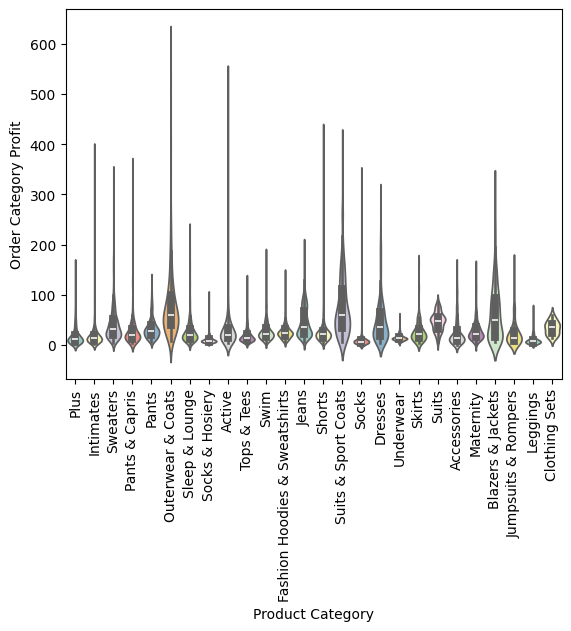

In [46]:
import matplotlib.pyplot as plt

sns.violinplot(data=aov_aop, x='product_category', y='order_category_profit',hue='product_category',palette="Set3")

# Set labels for the x and y axes
plt.xlabel('Product Category')
plt.ylabel('Order Category Profit')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

In [50]:
aov_aop.groupby('product_category')['order_category_profit'].median().reset_index().sort_values('order_category_profit')

,product_category,order_category_profit
18,Socks,6.279955
9,Leggings,7.015180
19,Socks & Hosiery,8.565300
14,Plus,12.010500
25,Underwear,13.245240
6,Intimates,13.284000
24,Tops & Tees,14.131170
0,Accessories,14.650000
8,Jumpsuits & Rompers,14.816080
13,Pants & Capris,19.115221


## Calculating Profit Margin and Contribution to Profit
 *  What does the distribution of profit margin look like within a given product category? Average for a product category? **Done**
 *  Define profitability - profit made per unit; compare what you would expect at full price v. actual **Done**
 *  Also consider contribution to total profits (fulfilled and NOT returned) 

In [52]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku as product_sku
    ,cost as product_cost
    ,category as product_category
    ,name as product_name
    ,brand as product_brand
    ,retail_price
    ,department
    ,retail_price - cost AS gross_profit
    ,((retail_price - cost)*1.00)/(retail_price*1.00) AS profit_margin
FROM
    `trumid-case.thelook_ecommerce.products`
)
SELECT
    *
FROM
    thelook_products

"""
product_with_margins = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [53]:
%matplotlib inline

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25],
 [Text(0, 0, 'Swim'),
  Text(1, 0, 'Jeans'),
  Text(2, 0, 'Pants'),
  Text(3, 0, 'Socks'),
  Text(4, 0, 'Active'),
  Text(5, 0, 'Shorts'),
  Text(6, 0, 'Sweaters'),
  Text(7, 0, 'Underwear'),
  Text(8, 0, 'Accessories'),
  Text(9, 0, 'Tops & Tees'),
  Text(10, 0, 'Sleep & Lounge'),
  Text(11, 0, 'Outerwear & Coats'),
  Text(12, 0, 'Suits & Sport Coats'),
  Text(13, 0, 'Fashion Hoodies & Sweatshirts'),
  Text(14, 0, 'Plus'),
  Text(15, 0, 'Suits'),
  Text(16, 0, 'Skirts'),
  Text(17, 0, 'Dresses'),
  Text(18, 0, 'Leggings'),
  Text(19, 0, 'Intimates'),
  Text(20, 0, 'Maternity'),
  Text(21, 0, 'Clothing Sets'),
  Text(22, 0, 'Pants & Capris'),
  Text(23, 0, 'Socks & Hosiery'),
  Text(24, 0, 'Blazers & Jackets'),
  Text(25, 0, 'Jumpsuits & Rompers')])

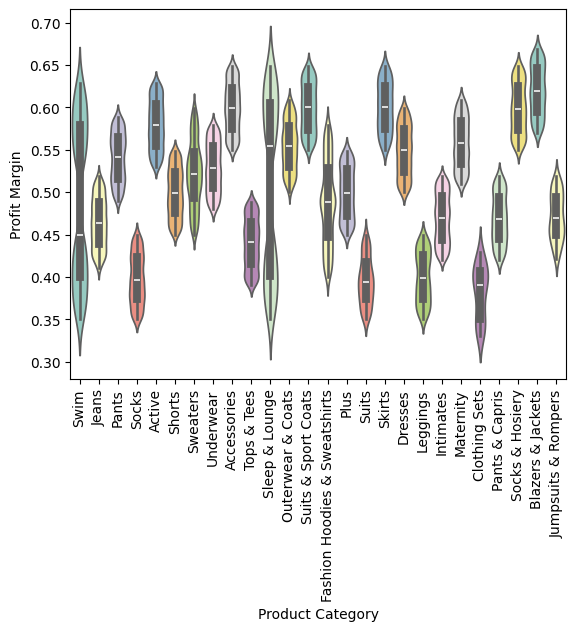

In [56]:
import matplotlib.pyplot as plt

sns.violinplot(data=product_with_margins, x='product_category', y='profit_margin',hue='product_category',palette="Set3")

# Set labels for the x and y axes
plt.xlabel('Product Category')
plt.ylabel('Profit Margin')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

### Now look at this against what's sold

- For items with biggest srpead of high v low margin, what doe sales look like?
- What areas are contributing most to profits? least?

In [57]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_order_items AS (
SELECT
    id as order_item_id
    ,product_id
    ,status
FROM
    `trumid-case.thelook_ecommerce.order_items`
)
SELECT
    status
    ,product_id
    ,COUNT(order_item_id) AS quantity
FROM
    thelook_order_items
GROUP BY
    status
    ,product_id
"""
volume_sold_by_status = pandas_gbq.read_gbq(query)
volume_sold_by_status['status'].unique()

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


array(['Complete', 'Shipped', 'Processing', 'Cancelled', 'Returned'],
      dtype=object)

In [58]:
volume_sold_by_status.head()

,status,product_id,quantity
0,Complete,12551,7
1,Complete,9518,6
2,Shipped,9137,6
3,Shipped,25244,7
4,Shipped,24932,6


To Do: join two dfs, exclude cancelled or returned. 
* Breakout total profit by category
* Look at profit and quantity (i.e. are there low margin items that aren't selling a lot?)

In [59]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_order_items AS (
SELECT
    product_id
    ,status
    ,COUNT(id) as quantity
FROM
    `trumid-case.thelook_ecommerce.order_items`
GROUP BY
    product_id
    ,status
),
thelook_products AS (
SELECT
    id as product_id
    ,sku as product_sku
    ,cost as product_cost
    ,category as product_category
    ,name as product_name
    ,brand as product_brand
    ,retail_price
    ,department
    ,retail_price - cost AS gross_profit
    ,((retail_price - cost)*1.00)/(retail_price*1.00) AS profit_margin
FROM
    `trumid-case.thelook_ecommerce.products`
)
SELECT
    thelook_products.product_id
    ,thelook_products.product_category
    ,thelook_products.product_sku
    ,thelook_products.product_cost
    ,thelook_products.retail_price
    ,thelook_products.gross_profit
    ,thelook_products.profit_margin
    ,COALESCE(thelook_order_items.status,'Never Ordered') as order_status
    ,COALESCE(thelook_order_items.quantity,0) as quantity
    
FROM
    thelook_products
LEFT JOIN
    thelook_order_items
ON
    thelook_products.product_id = thelook_order_items.product_id
"""
product_by_order_status = pandas_gbq.read_gbq(query) # 54 products were never ordered

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [60]:
product_by_order_status.head()

,product_id,product_category,product_sku,product_cost,retail_price,gross_profit,profit_margin,order_status,quantity
0,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,Complete,1
1,27569,Swim,B23C5765E165D83AA924FA8F13C05F25,92.652563,150.410004,57.757441,0.384,Returned,1
2,27445,Swim,2AB7D3B23574C3DEA2BD278AFD0939AB,24.719661,38.990002,14.270340,0.366,Shipped,2
3,27445,Swim,2AB7D3B23574C3DEA2BD278AFD0939AB,24.719661,38.990002,14.270340,0.366,Complete,2
4,27445,Swim,2AB7D3B23574C3DEA2BD278AFD0939AB,24.719661,38.990002,14.270340,0.366,Cancelled,1


In [61]:
product_by_order_status['order_status'].unique()

array(['Complete', 'Returned', 'Shipped', 'Cancelled', 'Processing',
       'Never Ordered'], dtype=object)

In [62]:
product_by_order_status.groupby(['product_category','order_status']).count().query("order_status == 'Never Ordered'")

,,product_id,product_sku,product_cost,retail_price,gross_profit,profit_margin,quantity
product_category,order_status,,,,,,,
Accessories,Never Ordered,2,2,2,2,2,2,2
Active,Never Ordered,3,3,3,3,3,3,3
Blazers & Jackets,Never Ordered,5,5,5,5,5,5,5
Dresses,Never Ordered,1,1,1,1,1,1,1
Fashion Hoodies & Sweatshirts,Never Ordered,4,4,4,4,4,4,4
Intimates,Never Ordered,4,4,4,4,4,4,4
Jeans,Never Ordered,4,4,4,4,4,4,4
Leggings,Never Ordered,2,2,2,2,2,2,2
Outerwear & Coats,Never Ordered,3,3,3,3,3,3,3


In [63]:
product_orders = product_by_order_status.query("order_status == 'Complete' | order_status == 'Shipped' | order_status == 'Processing'")
product_orders = product_orders.groupby(['product_id','product_sku','product_category','product_cost','retail_price','gross_profit','profit_margin'])['quantity'].sum()

In [65]:
product_orders = pd.DataFrame(product_orders).reset_index()

In [69]:
product_orders.query("product_cost > 500")

,product_id,product_sku,product_category,product_cost,retail_price,gross_profit,profit_margin,quantity
10300,10453,4801441F041958AFACA324C43C40787B,Intimates,512.001000,903.0,390.999000,0.433,7
16864,17094,08ED87BD895F5562AACFFD47D4C086EB,Fashion Hoodies & Sweatshirts,524.643000,903.0,378.357000,0.419,4
24621,24899,5D147304859C2C8752CF5DEDB4B50D49,Socks,557.151002,903.0,345.848998,0.383,5
25069,25348,27810D8AED732A494B7C10F1AAABCC8E,Socks,537.285001,903.0,365.714999,0.405,6


In [70]:
product_orders['total_profit'] = product_orders['gross_profit'].sum()
product_orders['percent_of_profit'] = product_orders['gross_profit'] / product_orders['total_profit']
product_orders['total_cost'] = product_orders['product_cost'].sum()
product_orders['percent_of_cost'] = product_orders['product_cost'] / product_orders['total_cost']
product_orders['total_revenue'] = product_orders['retail_price'].sum()
product_orders['percent_of_revenue'] = product_orders['retail_price'] / product_orders['total_revenue']
product_orders

,product_id,product_sku,product_category,product_cost,retail_price,gross_profit,profit_margin,quantity,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue
0,1,C4CA4238A0B923820DCC509A6F75849B,Tops & Tees,27.048000,49.000000,21.952000,0.448,4,886171.13471,0.000025,820922.947057,0.000033,1.707094e+06,0.000029
1,2,C81E728D9D4C2F636F067F89CC14862C,Tops & Tees,36.626500,69.500000,32.873500,0.473,3,886171.13471,0.000037,820922.947057,0.000045,1.707094e+06,0.000041
2,3,ECCBC87E4B5CE2FE28308FD9F2A7BAF3,Tops & Tees,41.005000,69.500000,28.495000,0.410,10,886171.13471,0.000032,820922.947057,0.000050,1.707094e+06,0.000041
3,4,A87FF679A2F3E71D9181A67B7542122C,Tops & Tees,57.132000,108.000000,50.868000,0.471,3,886171.13471,0.000057,820922.947057,0.000070,1.707094e+06,0.000063
4,5,E4DA3B7FBBCE2345D7772B0674A318D5,Tops & Tees,52.358000,94.000000,41.642000,0.443,4,886171.13471,0.000047,820922.947057,0.000064,1.707094e+06,0.000055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28815,29116,8AC8ABB13B9FE96F24FE2CAB11A18FC2,Accessories,36.023041,101.760002,65.736962,0.646,8,886171.13471,0.000074,820922.947057,0.000044,1.707094e+06,0.000060
28816,29117,A92DF7CBFDDDCC938ABC806992026A19,Accessories,40.392000,108.000000,67.608000,0.626,8,886171.13471,0.000076,820922.947057,0.000049,1.707094e+06,0.000063
28817,29118,857CD81E6A7D216EEAF1946A803A7D5E,Accessories,38.720000,110.000000,71.280000,0.648,3,886171.13471,0.000080,820922.947057,0.000047,1.707094e+06,0.000064
28818,29119,DC74D495021D5EB62F2A0DC42A47442B,Accessories,19.416419,48.419998,29.003579,0.599,4,886171.13471,0.000033,820922.947057,0.000024,1.707094e+06,0.000028


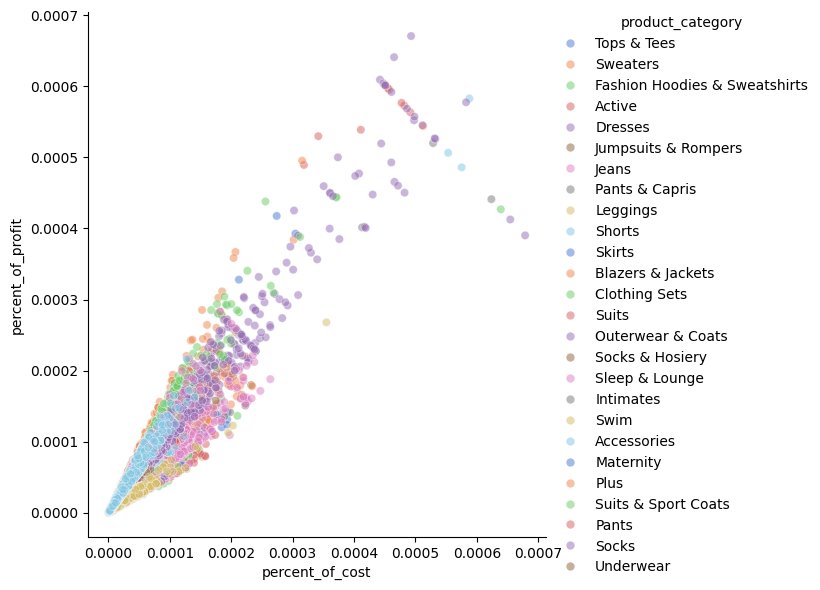

In [71]:
sns.relplot(x="percent_of_cost", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=product_orders)

In [72]:
import numpy as np
agg_product_details = product_orders.groupby('product_category').agg({"profit_margin": ['mean'],
                                                "retail_price": ['mean', 'sum'],
                                                "product_cost": ['mean', 'sum'],
                                                "gross_profit": ['mean', 'sum'],
                                                "quantity": ['sum']})
agg_product_details.columns = agg_product_details.columns.map('_'.join).str.strip('_')
agg_product_details = agg_product_details.reset_index()
agg_product_details.head()

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum
0,Accessories,0.599323,42.622325,65808.869959,17.087023,26382.363364,25.535302,39426.506595,7342
1,Active,0.579590,50.512440,71828.690041,21.167139,30099.671305,29.345302,41729.018736,6688
2,Blazers & Jackets,0.620084,92.474343,50675.940114,35.049121,19206.918250,57.425222,31469.021865,2374
3,Clothing Sets,0.381703,84.844054,3139.230003,52.507530,1942.778613,32.336524,1196.451391,156
4,Dresses,0.548794,84.137373,79425.680192,37.881543,35760.176754,46.255830,43665.503438,4060


In [73]:
agg_product_details['total_profit'] = agg_product_details['gross_profit_sum'].sum()
agg_product_details['percent_of_profit'] = agg_product_details['gross_profit_sum'] / agg_product_details['total_profit']
agg_product_details['total_cost'] = agg_product_details['product_cost_sum'].sum()
agg_product_details['percent_of_cost'] = agg_product_details['product_cost_sum'] / agg_product_details['total_cost']
agg_product_details['total_revenue'] = agg_product_details['retail_price_sum'].sum()
agg_product_details['percent_of_revenue'] = agg_product_details['retail_price_sum'] / agg_product_details['total_revenue']
agg_product_details

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue
0,Accessories,0.599323,42.622325,65808.869959,17.087023,26382.363364,25.535302,39426.506595,7342,886171.13471,0.044491,820922.947057,0.032137,1.707094e+06,0.038550
1,Active,0.579590,50.512440,71828.690041,21.167139,30099.671305,29.345302,41729.018736,6688,886171.13471,0.047089,820922.947057,0.036666,1.707094e+06,0.042077
2,Blazers & Jackets,0.620084,92.474343,50675.940114,35.049121,19206.918250,57.425222,31469.021865,2374,886171.13471,0.035511,820922.947057,0.023397,1.707094e+06,0.029685
3,Clothing Sets,0.381703,84.844054,3139.230003,52.507530,1942.778613,32.336524,1196.451391,156,886171.13471,0.001350,820922.947057,0.002367,1.707094e+06,0.001839
4,Dresses,0.548794,84.137373,79425.680192,37.881543,35760.176754,46.255830,43665.503438,4060,886171.13471,0.049274,820922.947057,0.043561,1.707094e+06,0.046527
5,Fashion Hoodies & Sweatshirts,0.487730,53.926111,99547.600082,27.827053,51368.739239,26.099058,48178.860844,8773,886171.13471,0.054367,820922.947057,0.062574,1.707094e+06,0.058314
6,Intimates,0.469318,33.693268,78471.620110,17.918155,41731.381986,15.775113,36740.238123,10067,886171.13471,0.041460,820922.947057,0.050835,1.707094e+06,0.045968
7,Jeans,0.464351,98.110790,193768.810269,52.538468,103763.474354,45.572322,90005.335916,9372,886171.13471,0.101567,820922.947057,0.126399,1.707094e+06,0.113508
8,Jumpsuits & Rompers,0.471335,42.288137,6808.390022,22.396962,3605.910807,19.891175,3202.479215,692,886171.13471,0.003614,820922.947057,0.004393,1.707094e+06,0.003988
9,Leggings,0.399905,27.233667,15223.619977,16.335991,9131.819021,10.897676,6091.800956,2407,886171.13471,0.006874,820922.947057,0.011124,1.707094e+06,0.008918


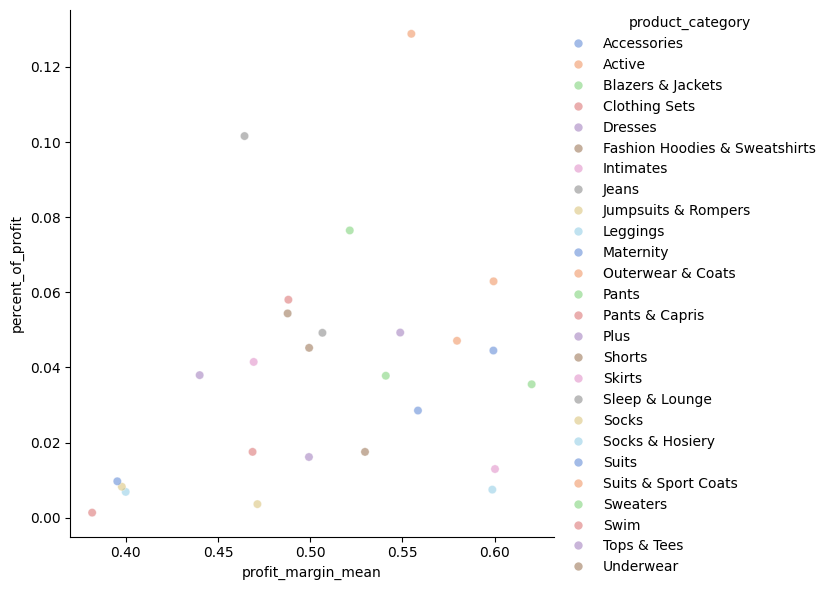

In [74]:
sns.relplot(x="profit_margin_mean", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

In [75]:
agg_product_details.query("profit_margin_mean <= 0.45 & percent_of_profit <= 0.04")

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue
3,Clothing Sets,0.381703,84.844054,3139.230003,52.507530,1942.778613,32.336524,1196.451391,156,886171.13471,0.001350,820922.947057,0.002367,1.707094e+06,0.001839
9,Leggings,0.399905,27.233667,15223.619977,16.335991,9131.819021,10.897676,6091.800956,2407,886171.13471,0.006874,820922.947057,0.011124,1.707094e+06,0.008918
18,Socks,0.397809,20.462978,18416.680007,12.344891,11110.401853,8.118087,7306.278154,4692,886171.13471,0.008245,820922.947057,0.013534,1.707094e+06,0.010788
20,Suits,0.395348,116.072086,21705.480022,70.130908,13114.479795,45.941178,8591.000227,808,886171.13471,0.009695,820922.947057,0.015975,1.707094e+06,0.012715
24,Tops & Tees,0.440022,41.352920,76337.490261,23.137844,42712.459363,18.215076,33625.030898,8917,886171.13471,0.037944,820922.947057,0.052030,1.707094e+06,0.044718


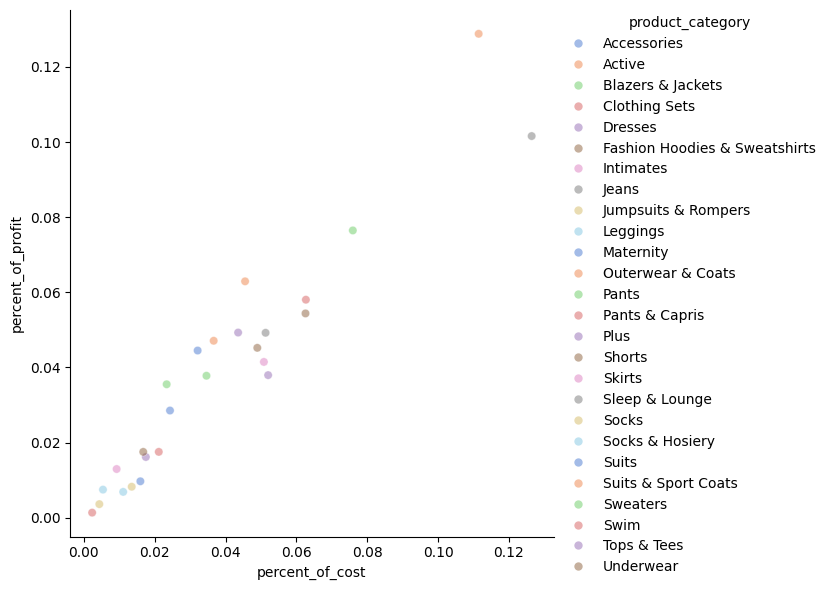

In [76]:
sns.relplot(x="percent_of_cost", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

<Axes: >

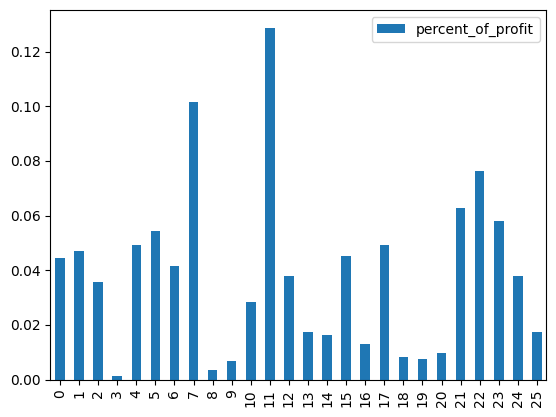

In [92]:
agg_product_details[['product_category','percent_of_profit']].plot(kind='bar', stacked=True)

<Axes: >

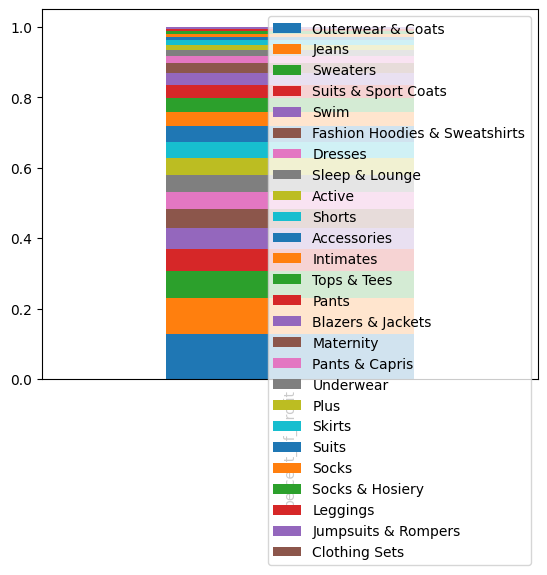

In [117]:
category_profit = agg_product_details[['product_category','percent_of_profit']].sort_values('percent_of_profit',ascending=False).transpose()
headers = category_profit.iloc[0].values
category_profit.columns = headers
category_profit.query("Accessories != 'Accessories'").plot(kind='bar', stacked=True)

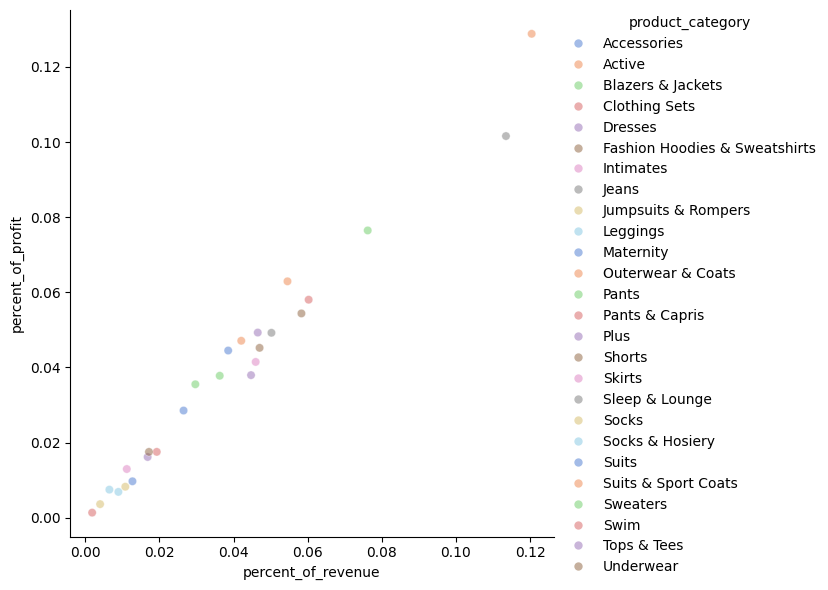

In [77]:
sns.relplot(x="percent_of_revenue", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

In [78]:
agg_product_details.query("percent_of_cost > percent_of_profit").sort_values('percent_of_profit')

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue
3,Clothing Sets,0.381703,84.844054,3139.230003,52.507530,1942.778613,32.336524,1196.451391,156,886171.13471,0.001350,820922.947057,0.002367,1.707094e+06,0.001839
8,Jumpsuits & Rompers,0.471335,42.288137,6808.390022,22.396962,3605.910807,19.891175,3202.479215,692,886171.13471,0.003614,820922.947057,0.004393,1.707094e+06,0.003988
9,Leggings,0.399905,27.233667,15223.619977,16.335991,9131.819021,10.897676,6091.800956,2407,886171.13471,0.006874,820922.947057,0.011124,1.707094e+06,0.008918
18,Socks,0.397809,20.462978,18416.680007,12.344891,11110.401853,8.118087,7306.278154,4692,886171.13471,0.008245,820922.947057,0.013534,1.707094e+06,0.010788
20,Suits,0.395348,116.072086,21705.480022,70.130908,13114.479795,45.941178,8591.000227,808,886171.13471,0.009695,820922.947057,0.015975,1.707094e+06,0.012715
14,Plus,0.499290,38.375348,28704.760052,19.233339,14386.537797,19.142008,14318.222255,3224,886171.13471,0.016157,820922.947057,0.017525,1.707094e+06,0.016815
13,Pants & Capris,0.468708,54.666728,32909.370129,28.869464,17379.417223,25.797264,15529.952905,2561,886171.13471,0.017525,820922.947057,0.021171,1.707094e+06,0.019278
24,Tops & Tees,0.440022,41.352920,76337.490261,23.137844,42712.459363,18.215076,33625.030898,8917,886171.13471,0.037944,820922.947057,0.052030,1.707094e+06,0.044718
6,Intimates,0.469318,33.693268,78471.620110,17.918155,41731.381986,15.775113,36740.238123,10067,886171.13471,0.041460,820922.947057,0.050835,1.707094e+06,0.045968
15,Shorts,0.499388,45.865892,80265.310226,22.972838,40202.466094,22.893054,40062.844133,8321,886171.13471,0.045209,820922.947057,0.048972,1.707094e+06,0.047019


In [79]:
product_orders.query("product_category == 'Clothing Sets'").sort_values('profit_margin')

,product_id,product_sku,product_category,product_cost,retail_price,gross_profit,profit_margin,quantity,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue
7940,8054,47E51E9D11CF800FF08674DBB68A48AB,Clothing Sets,66.993298,99.989998,32.996699,0.330,6,886171.13471,0.000037,820922.947057,0.000082,1.707094e+06,0.000059
7920,8034,CC4AF25FA9D2D5C953496579B75F6F6C,Clothing Sets,73.693298,109.989998,36.296700,0.330,6,886171.13471,0.000041,820922.947057,0.000090,1.707094e+06,0.000064
7938,8052,93C83A131FA0FD208E161910A17519C4,Clothing Sets,80.280000,120.000000,39.720000,0.331,4,886171.13471,0.000045,820922.947057,0.000098,1.707094e+06,0.000070
7948,8062,EE492A6C8F567FB3100B7DC9D3600CBE,Clothing Sets,46.092000,69.000000,22.908000,0.332,3,886171.13471,0.000026,820922.947057,0.000056,1.707094e+06,0.000040
7930,8044,5588902A8054F6E22ED3484C140FFC62,Clothing Sets,38.940000,59.000000,20.060000,0.340,3,886171.13471,0.000023,820922.947057,0.000047,1.707094e+06,0.000035
7916,8030,B4D22BB574AED5FDD900A274930252F6,Clothing Sets,32.900000,50.000000,17.100000,0.342,4,886171.13471,0.000019,820922.947057,0.000040,1.707094e+06,0.000029
7921,8035,A2B8A85A29B2D64AD6F47275BF1360C6,Clothing Sets,104.303999,159.000000,54.696001,0.344,2,886171.13471,0.000062,820922.947057,0.000127,1.707094e+06,0.000093
7923,8037,3A9DE64A6C62C8CD6FF8320BAFB8452F,Clothing Sets,25.538451,38.990002,13.451551,0.345,1,886171.13471,0.000015,820922.947057,0.000031,1.707094e+06,0.000023
7913,8027,E6D80593A7D6BB499229C85E7FA4E7AE,Clothing Sets,35.798491,54.990002,19.191511,0.349,3,886171.13471,0.000022,820922.947057,0.000044,1.707094e+06,0.000032
7934,8048,48DFB0E62EF53DC160C26788433C2D1A,Clothing Sets,37.635511,57.990002,20.354491,0.351,3,886171.13471,0.000023,820922.947057,0.000046,1.707094e+06,0.000034


In [80]:
agg_product_details['profitability'] = agg_product_details['gross_profit_sum'] / agg_product_details['product_cost_sum']
agg_product_details.sort_values('profitability')

,product_category,profit_margin_mean,retail_price_mean,retail_price_sum,product_cost_mean,product_cost_sum,gross_profit_mean,gross_profit_sum,quantity_sum,total_profit,percent_of_profit,total_cost,percent_of_cost,total_revenue,percent_of_revenue,profitability
3,Clothing Sets,0.381703,84.844054,3139.230003,52.507530,1942.778613,32.336524,1196.451391,156,886171.13471,0.001350,820922.947057,0.002367,1.707094e+06,0.001839,0.615845
20,Suits,0.395348,116.072086,21705.480022,70.130908,13114.479795,45.941178,8591.000227,808,886171.13471,0.009695,820922.947057,0.015975,1.707094e+06,0.012715,0.655077
18,Socks,0.397809,20.462978,18416.680007,12.344891,11110.401853,8.118087,7306.278154,4692,886171.13471,0.008245,820922.947057,0.013534,1.707094e+06,0.010788,0.657607
9,Leggings,0.399905,27.233667,15223.619977,16.335991,9131.819021,10.897676,6091.800956,2407,886171.13471,0.006874,820922.947057,0.011124,1.707094e+06,0.008918,0.667096
24,Tops & Tees,0.440022,41.352920,76337.490261,23.137844,42712.459363,18.215076,33625.030898,8917,886171.13471,0.037944,820922.947057,0.052030,1.707094e+06,0.044718,0.787242
7,Jeans,0.464351,98.110790,193768.810269,52.538468,103763.474354,45.572322,90005.335916,9372,886171.13471,0.101567,820922.947057,0.126399,1.707094e+06,0.113508,0.867409
6,Intimates,0.469318,33.693268,78471.620110,17.918155,41731.381986,15.775113,36740.238123,10067,886171.13471,0.041460,820922.947057,0.050835,1.707094e+06,0.045968,0.880398
8,Jumpsuits & Rompers,0.471335,42.288137,6808.390022,22.396962,3605.910807,19.891175,3202.479215,692,886171.13471,0.003614,820922.947057,0.004393,1.707094e+06,0.003988,0.888119
13,Pants & Capris,0.468708,54.666728,32909.370129,28.869464,17379.417223,25.797264,15529.952905,2561,886171.13471,0.017525,820922.947057,0.021171,1.707094e+06,0.019278,0.893583
5,Fashion Hoodies & Sweatshirts,0.487730,53.926111,99547.600082,27.827053,51368.739239,26.099058,48178.860844,8773,886171.13471,0.054367,820922.947057,0.062574,1.707094e+06,0.058314,0.937902


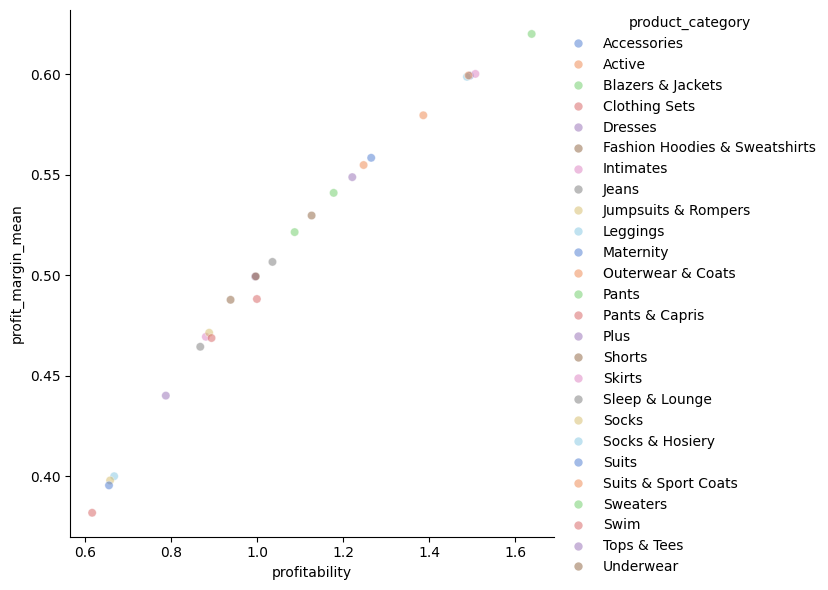

In [81]:
sns.relplot(x="profitability", y="profit_margin_mean", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

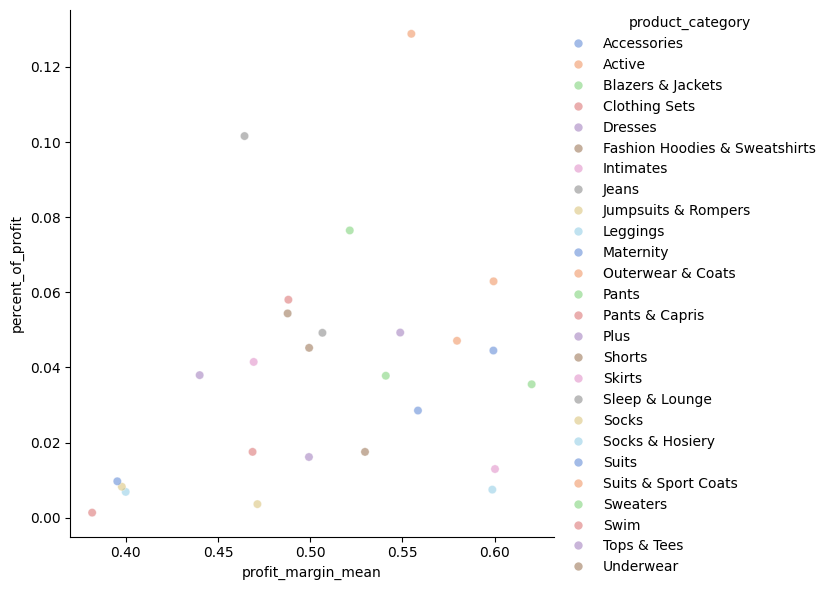

In [86]:
sns.relplot(x="profit_margin_mean", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)

### Takeways:
* Items like clothing sets, jumpsuits/rompers, socks, suits have low profitability (both on margins and overall).
* Active, suits/sportcoats/blazers are all high margin and high profitability
* All items are sold full price, so could consider whether there's price sensitivity on items that don't sell (such as?)


### Next Steps
* Look at item turnover, average order value and profit per order, categories purchased by highest aov/aop users

In [254]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
    ,category
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,user_id
    ,order_id
    ,product_id
    ,sale_price
    ,status
FROM
    `trumid-case.thelook_ecommerce.order_items`
WHERE
    status != 'Returned' AND status != 'Cancelled'
),
order_product_details AS (
SELECT
   thelook_orderitems.user_id
   ,thelook_orderitems.order_id
   ,thelook_orderitems.order_item_id
   ,thelook_products.category
   ,thelook_products.product_id
   ,thelook_orderitems.sale_price
   ,thelook_products.cost
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    order_id
    ,category
    ,COUNT(order_item_id) AS count_order_items
    ,COUNT(DISTINCT product_id) AS count_products
    ,SUM(sale_price) AS order_category_revenue
    ,SUM(cost) AS order_category_cost
    ,SUM(sale_price - cost) AS order_category_profit
FROM
    order_product_details
GROUP BY
    order_id
    ,category
ORDER BY
    count_order_items DESC
"""
order_category_spend = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [249]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
    ,category
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,user_id
    ,order_id
    ,product_id
    ,sale_price
    ,status
FROM
    `trumid-case.thelook_ecommerce.order_items`
WHERE
    status != 'Returned' AND status != 'Cancelled'
),
order_product_details AS (
SELECT
   thelook_orderitems.user_id
   ,thelook_orderitems.order_id
   ,thelook_orderitems.order_item_id
   ,thelook_products.category
   ,thelook_products.product_id
   ,thelook_orderitems.sale_price
   ,thelook_products.cost
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    user_id
    ,COUNT(DISTINCT order_id) AS count_orders
    ,COUNT(order_item_id) AS count_order_items
    ,COUNT(DISTINCT product_id) AS count_products
    ,SUM(sale_price) AS total_order_value
    ,SUM(cost) AS total_order_cost
    ,SUM(sale_price - cost) AS total_order_profit
    ,AVG(sale_price) AS average_order_value
    ,AVG(cost) AS average_order_cost
    ,AVG(sale_price - cost) AS average_order_profit
FROM
    order_product_details
GROUP BY
    user_id
ORDER BY
    average_order_value DESC
"""
user_spend = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [250]:
user_spend.head()

,user_id,count_orders,count_order_items,count_products,total_order_value,total_order_cost,total_order_profit,average_order_value,average_order_cost,average_order_profit
0,51098,1,1,1,999.0,404.595001,594.404999,999.0,404.595001,594.404999
1,68889,1,1,1,999.0,482.516999,516.483001,999.0,482.516999,516.483001
2,26670,1,1,1,950.0,381.900002,568.099998,950.0,381.900002,568.099998
3,1147,1,1,1,903.0,399.126001,503.873999,903.0,399.126001,503.873999
4,7536,1,1,1,903.0,524.643000,378.357000,903.0,524.643000,378.357000


In [247]:
user_spend.query("count_orders != 1").sort_values('total_order_profit',ascending=False)

,user_id,count_orders,count_order_items,count_products,total_order_value,total_order_cost,total_order_profit,average_order_value,average_order_cost,average_order_profit
0,41990,3,8,8,1742.980000,774.870541,968.109459,217.872500,96.858818,121.013682
1,9162,4,7,7,1574.890001,691.555034,883.334968,224.984286,98.793576,126.190710
2,21638,2,5,5,1356.659992,569.190499,787.469493,271.331998,113.838100,157.493899
3,96840,2,5,5,1350.990002,591.949361,759.040641,270.198000,118.389872,151.808128
4,99145,3,6,6,1346.649988,590.408054,756.241934,224.441665,98.401342,126.040322
...,...,...,...,...,...,...,...,...,...,...
63415,46309,2,2,2,13.960000,7.579650,6.380350,6.980000,3.789825,3.190175
63472,87440,2,2,2,12.560000,6.234400,6.325600,6.280000,3.117200,3.162800
64399,39505,2,2,2,11.090000,5.685410,5.404590,5.545000,2.842705,2.702295
64579,73751,2,2,2,10.700000,5.476240,5.223760,5.350000,2.738120,2.611880


In [251]:
user_spend.query("count_orders != 1").sort_values('average_order_value',ascending=False)

,user_id,count_orders,count_order_items,count_products,total_order_value,total_order_cost,total_order_profit,average_order_value,average_order_cost,average_order_profit
79,72112,2,2,2,1060.889999,426.123061,634.766938,530.445,213.061531,317.383469
80,11972,2,2,2,1059.000000,428.115001,630.884999,529.500,214.057501,315.442499
88,54054,2,2,2,1036.500000,495.979499,540.520501,518.250,247.989749,270.260251
90,25743,2,2,2,1017.000000,491.859003,525.140997,508.500,245.929501,262.570499
91,98068,2,2,2,1015.000000,489.070003,525.929997,507.500,244.535001,262.964999
...,...,...,...,...,...,...,...,...,...,...
65908,99683,2,2,2,12.940000,5.097820,7.842180,6.470,2.548910,3.921090
65931,87440,2,2,2,12.560000,6.234400,6.325600,6.280,3.117200,3.162800
66029,39505,2,2,2,11.090000,5.685410,5.404590,5.545,2.842705,2.702295
66035,73751,2,2,2,10.700000,5.476240,5.223760,5.350,2.738120,2.611880


In [245]:
user_spend.query("count_orders == 1")

,user_id,count_orders,count_order_items,count_products,total_order_value,total_order_cost,total_order_profit,average_order_value,average_order_cost,average_order_profit
9,27956,1,4,4,1188.990005,479.421283,709.568723,297.247501,119.855321,177.392181
23,25069,1,3,3,1182.829998,519.084111,663.745887,394.276666,173.028037,221.248629
25,39094,1,4,4,1137.949997,483.131401,654.818596,284.487499,120.782850,163.704649
30,91567,1,2,2,1248.000000,600.330001,647.669999,624.000000,300.165001,323.834999
40,74958,1,4,4,1222.980000,590.061019,632.918981,305.745000,147.515255,158.229745
...,...,...,...,...,...,...,...,...,...,...
66224,88508,1,1,1,1.500000,0.606000,0.894000,1.500000,0.606000,0.894000
66225,87003,1,1,1,1.500000,0.618000,0.882000,1.500000,0.618000,0.882000
66226,58484,1,1,1,1.500000,0.618000,0.882000,1.500000,0.618000,0.882000
66227,73286,1,1,1,1.510000,0.644770,0.865230,1.510000,0.644770,0.865230


## Question 2

In [213]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    *
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    user_id is NULL
AND event_type = 'cancel'
LIMIT 100
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,1942426,<NA>,3,0c57fd19-e3ab-4dde-b09a-e36951383509,2021-09-27 19:09:00+00:00,191.106.209.158,Bogatynia,Dolnośląskie,59,Safari,Email,/cancel,cancel
1,1964624,<NA>,3,6cd5677f-03a4-4e64-92a7-4979a7b813de,2023-08-04 13:10:00+00:00,14.107.96.253,Bogatynia,Dolnośląskie,59,Other,Organic,/cancel,cancel
2,1474312,<NA>,3,e0681fe9-8707-4543-8912-7adfc733c71c,2023-09-16 08:08:00+00:00,78.193.90.139,Bogatynia,Dolnośląskie,59,Safari,Email,/cancel,cancel
3,1722448,<NA>,3,c0778e17-acc6-4281-80f8-ecd4fe4bf0d0,2020-05-31 09:02:00+00:00,4.164.33.46,Bogatynia,Dolnośląskie,59,Safari,Email,/cancel,cancel
4,1299352,<NA>,3,645c3ef1-4422-4fdb-8757-6b18440804a8,2019-06-07 08:08:00+00:00,76.214.252.33,Bogatynia,Dolnośląskie,59,Chrome,YouTube,/cancel,cancel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1554413,<NA>,3,3bdc2192-2999-459c-ac9a-6c4276800b0d,2020-11-23 12:46:00+00:00,187.136.3.111,Writtle,England,CM1,Chrome,Adwords,/cancel,cancel
96,1367152,<NA>,3,8c78e520-6d8e-49fe-8701-88f1233dd9e8,2020-02-14 06:36:00+00:00,59.145.29.241,Boreham,England,CM3,Firefox,Email,/cancel,cancel
97,1359971,<NA>,3,b48d11d1-85a3-46a6-a53f-3739f592822f,2022-07-04 08:11:00+00:00,134.138.8.137,Maldon,England,CM9,Firefox,Email,/cancel,cancel
98,2100045,<NA>,3,6766ec77-a568-4542-b421-acb4de2c7259,2023-02-09 05:07:00+00:00,174.39.151.219,Colchester,England,CO2,Chrome,Adwords,/cancel,cancel


In [208]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    *
FROM
     `trumid-case.thelook_ecommerce.products`
WHERE
    id = 8088
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id
0,8088,130.127402,Suits,Kasper 3 Piece Eternal City Pant Suit,Kasper,215.800003,Women,172EF5A94B4DD0AA120C6878FC29F70C,9


In [205]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    event_type
    ,count(*)
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    user_id IS NULL
GROUP BY
    event_type
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,event_type,f0_
0,cart,249818
1,cancel,124677
2,product,500000
3,department,250255


In [209]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    DISTINCT event_type
FROM
     `trumid-case.thelook_ecommerce.events`
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,event_type
0,cart
1,home
2,cancel
3,product
4,purchase
5,department


In [ ]:
## No user ID --> Never bought
## User ID -->  Bought

In [215]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    count(distinct session_id) as num_sessions
    ,count(distinct case when event_type = 'purchase' then session_id else null end) as num_purchase_sessions
FROM
     `trumid-case.thelook_ecommerce.events`
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_sessions,num_purchase_sessions
0,681028,181028


In [219]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    count(distinct session_id) as num_sessions
    ,count(distinct case when event_type = 'cancel' then session_id else null end) as num_cancel_sessions
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE 
    user_id IS NOT NULL
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_sessions,num_cancel_sessions
0,181028,0


In [221]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    count(distinct session_id) as num_sessions
    ,count(distinct case when event_type = 'purchase' then session_id else null end) as num_cancel_sessions
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE 
    user_id IS NOT NULL
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_sessions,num_cancel_sessions
0,181028,181028


In [220]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    count(distinct session_id) as num_sessions
    ,count(distinct case when event_type = 'cancel' then session_id else null end) as num_cancel_sessions
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE 
    user_id IS NULL
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_sessions,num_cancel_sessions
0,500000,124677


In [227]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    session_id,
    max(sequence_number)
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY 1
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,session_id,f0_
0,0be43e50-e17d-4636-b211-9e3658cac37a,1
1,c836ffa5-298a-45fd-a92c-d1dfee9d5c25,1
2,2c3920d9-412a-4535-b7a1-17ec14725edc,1
3,4b7588a4-9132-4645-9216-d557a31955a6,1
4,cfcdaef1-3805-4bd4-8768-5f00127de3a5,1
...,...,...
681023,22ec59cf-8b2c-4470-8893-05103a1bcdc8,13
681024,c49cd461-00df-425f-ada9-c21afb7b7c27,13
681025,2d069d42-559c-4c8f-8309-0bf1907dc4e7,13
681026,54eec890-e967-40dc-9ed3-2882d922250e,13


In [230]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    *
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    session_id = 'e0681fe9-8707-4543-8912-7adfc733c71c'
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,id,user_id,sequence_number,session_id,created_at,ip_address,city,state,postal_code,browser,traffic_source,uri,event_type
0,1474310,<NA>,1,e0681fe9-8707-4543-8912-7adfc733c71c,2023-09-16 07:24:00+00:00,78.193.90.139,Bogatynia,Dolnośląskie,59,Safari,Email,/product/5127,product
1,1474311,<NA>,2,e0681fe9-8707-4543-8912-7adfc733c71c,2023-09-16 07:45:00+00:00,78.193.90.139,Bogatynia,Dolnośląskie,59,Safari,Email,/cart,cart
2,1474312,<NA>,3,e0681fe9-8707-4543-8912-7adfc733c71c,2023-09-16 08:08:00+00:00,78.193.90.139,Bogatynia,Dolnośląskie,59,Safari,Email,/cancel,cancel


In [229]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
SELECT
    event_type,
    COUNT(*)
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    sequence_number = 1
GROUP BY 1
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,event_type,f0_
0,home,87396
1,product,249745
2,department,343887


conversion rate = number of sessions that end in a purchase
181028/681028

* Can look at among registered users what differs between successful and unsuccessful purchases
  * Where does the funnel breakdown?
* Can look for similarities among unsuccessful without user id (brand, product, location)